In [1]:
from eppy import modeleditor
from eppy.modeleditor import IDF
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import matplotlib.pyplot as plt

In [2]:
#idd_file='/home/ict4bd_v2/Desktop/building/energyplus/EnergyPlus-9-0-1/Energy+.idd'
iddfile='/home/ict4bd_v2/Desktop/building/energyplus/EnergyPlus-9-0-1/Energy+.idd'
fname = '/home/ict4bd_v2/Desktop/project/on_double.idf'
weather='/home/ict4bd_v2/Desktop/project/ITA_Torino_160590_IWEC.epw'
IDF.setiddname(iddfile)
idf = IDF(fname,weather)

In [3]:
zones = idf.idfobjects["ZONE"]
total_area=0
for i in range(len(zones)):
    zone = zones[i]
    area = modeleditor.zonearea(idf, zone.Name)
    total_area=total_area+area

print("total one area = %s" % (total_area, ))

total one area = 1084.534275140951


In [4]:
samples_temp =[]
samples_temp.append({'Orientation': 270,
                     'Insulation Thickness': 0.35,
                     'Window to Wall Ratio': 0.15,})
samples = pd.DataFrame.from_dict(samples_temp)
samples

,Orientation,Insulation Thickness,Window to Wall Ratio
0,270,0.35,0.15


In [5]:
building = ef.get_building(fname)
insulation = FieldSelector(class_name='Material', object_name='MW Glass Wool (rolls)_O.1445', 
                           field_name='Thickness')
insulationPR=Parameter(selector=insulation,name='Insulation Thickness')

window_to_wall = wwr(CategoryParameter([0.15])) 

orientation = FieldSelector(class_name='Building', field_name='North Axis')
orientationPR = Parameter(selector=orientation, value_descriptor=CategoryParameter(options=[270]),
                          name='Orientation')

parameters = [orientationPR , window_to_wall, insulationPR]
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`
problem=EPProblem(parameters, objectives) # problem = parameters + objectives

/home/ict4bd_v2/py3/lib/python3.8/site-packages/besos-1.7.0-py3.8.egg/besos/eppy_funcs.py:108: UserWarning: idd is already set to: /home/ict4bd_v2/Desktop/building/energyplus/EnergyPlus-9-0-1/Energy+.idd. It will NOT be changed to the default of: /usr/local/EnergyPlus-9-0-1/Energy+.idd.
  warnings.warn(
/home/ict4bd_v2/py3/lib/python3.8/site-packages/besos-1.7.0-py3.8.egg/besos/parameters.py:592: UserWarning: wwr is intended to be used with RangeParameter. Your value_descriptor is CategoryParameter(options=[0.15])
  warnings.warn(


In [6]:
evaluator = EvaluatorEP(problem, building, out_dir='sim_outputdir', err_dir='sim_outputdir' ,
                        epw=weather) # evaluator = problem + building

In [7]:
#simulation 2019
run_period = idf.idfobjects['RunPeriod'][0]
run_period.Begin_Year = 2017
run_period.End_Year = 2017
run_period
idf.idfobjects['RunPeriod'][0]


RunPeriod,
    lab_part1 (O1-O1:31-12),    !- Name
    1,                        !- Begin Month
    1,                        !- Begin Day of Month
    2017,                     !- Begin Year
    12,                       !- End Month
    31,                       !- End Day of Month
    2017,                     !- End Year
    ,                         !- Day of Week for Start Day
    No,                       !- Use Weather File Holidays and Special Days
    No,                       !- Use Weather File Daylight Saving Period
    Yes,                      !- Apply Weekend Holiday Rule
    Yes,                      !- Use Weather File Rain Indicators
    Yes,                      !- Use Weather File Snow Indicators
    ;                         !- Treat Weather as Actual

In [37]:
#monthly simulation
for i in range(len(idf.idfobjects['OUTPUT:VARIABLE'])):
    idf.idfobjects['OUTPUT:VARIABLE'][i].Reporting_Frequency='monthly'
for i in range(len(idf.idfobjects['OUTPUT:METER'])):
    idf.idfobjects['OUTPUT:METER'][i].Reporting_Frequency='monthly'
idf.idfobjects['OUTPUT:ENVIRONMENTALIMPACTFACTORS'][0].Reporting_Frequency='monthly'

In [38]:
#Now we run the evaluator with the given parameters
result = evaluator([270,0.15,0.35]) 
values = dict(zip(objectives, result))
for key, value in values.items():
    print(key, " :: ", "{0:.2f}".format(value/3.6e6), "kWh")

Electricity:Facility  ::  50169.43 kWh
DistrictHeating:Facility  ::  37120.58 kWh
DistrictCooling:Facility  ::  7722.42 kWh


In [39]:
idf.run(readvars=True,output_directory=u'simulation_output/output_EPPY_daily',annual= True)
idf_data =pd.read_csv('/home/ict4bd_v2/Desktop/project/simulation_output/output_EPPY_daily/eplusout.csv')


/home/ict4bd_v2/Desktop/building/energyplus/EnergyPlus-9-0-1/energyplus --weather /home/ict4bd_v2/Desktop/project/ITA_Torino_160590_IWEC.epw --output-directory /home/ict4bd_v2/Desktop/project/simulation_output/output_EPPY_daily --annual --idd /home/ict4bd_v2/Desktop/building/energyplus/EnergyPlus-9-0-1/Energy+.idd --readvars /home/ict4bd_v2/Desktop/project/in.idf



In [40]:
for i in idf_data.columns:
    if 'Temperature' in i and 'Zone' in i:
        print(i)

BLOCK1:ZONE3:Zone Mean Radiant Temperature [C](Monthly)
BLOCK1:ZONE1:Zone Mean Radiant Temperature [C](Monthly)
BLOCK1:ZONE4:Zone Mean Radiant Temperature [C](Monthly)
BLOCK1:ZONE2:Zone Mean Radiant Temperature [C](Monthly)
BLOCK1:ZONE3:Zone Mean Air Temperature [C](Monthly)
BLOCK1:ZONE3:Zone Operative Temperature [C](Monthly)
BLOCK1:ZONE1:Zone Mean Air Temperature [C](Monthly)
BLOCK1:ZONE1:Zone Operative Temperature [C](Monthly)
BLOCK1:ZONE4:Zone Mean Air Temperature [C](Monthly)
BLOCK1:ZONE4:Zone Operative Temperature [C](Monthly)
BLOCK1:ZONE2:Zone Mean Air Temperature [C](Monthly)
BLOCK1:ZONE2:Zone Operative Temperature [C](Monthly)


In [49]:
#getting required columns 
columns=['Date/Time']
for i in idf_data.columns:
    if ('Zone Operative Temperature' in i or 'District' in i or 'Electricity:Facility' in i or 'Drybulb' in i) and ('Monthly' in i): 
        columns=columns+[i]
columns

['Date/Time',
 'Environment:Site Outdoor Air Drybulb Temperature [C](Monthly)',
 'BLOCK1:ZONE3:Zone Operative Temperature [C](Monthly)',
 'BLOCK1:ZONE1:Zone Operative Temperature [C](Monthly)',
 'BLOCK1:ZONE4:Zone Operative Temperature [C](Monthly)',
 'BLOCK1:ZONE2:Zone Operative Temperature [C](Monthly)',
 'Electricity:Facility [J](Monthly)',
 'DistrictCooling:Facility [J](Monthly)',
 'DistrictHeating:Facility [J](Monthly)']

In [50]:
df_columns = {'Date/Time':'Date_Time',
              'Environment:Site Outdoor Air Drybulb Temperature [C](Monthly)':'t_out',
              'BLOCK1:ZONE3:Zone Operative Temperature [C](Monthly)':'t_in_ZONE3',
              'BLOCK1:ZONE1:Zone Operative Temperature [C](Monthly)':'t_in_ZONE1',
              'BLOCK1:ZONE4:Zone Operative Temperature [C](Monthly)':'t_in_ZONE4',
              'BLOCK1:ZONE2:Zone Operative Temperature [C](Monthly)':'t_in_ZONE2',
              'DistrictHeating:Facility [J](Monthly)':'power_heating',
              'DistrictCooling:Facility [J](Monthly)':'power_cooling' ,
              'Electricity:Facility [J](Monthly)':'power_electricity'}


In [51]:
idf_data=idf_data[columns]
data = idf_data.rename(columns =df_columns)
data

,Date_Time,t_out,t_in_ZONE3,t_in_ZONE1,t_in_ZONE4,t_in_ZONE2,power_electricity,power_cooling,power_heating
0,January,1.782762,15.616027,15.401271,15.723816,15.732573,1.534174e+10,0.000000e+00,3.655639e+10
1,February,3.853981,16.017863,16.035280,16.146847,16.162527,1.385350e+10,0.000000e+00,2.526517e+10
2,March,8.136492,17.194120,18.028847,17.385082,17.435563,1.531424e+10,0.000000e+00,1.434032e+10
3,April,11.863958,18.603555,20.097408,18.752856,18.892319,1.488232e+10,0.000000e+00,5.427686e+09
4,May,16.000000,21.506650,22.673998,21.511605,21.668914,1.531424e+10,7.832072e+08,2.362052e+09
5,June,19.480694,23.374247,24.233709,23.319779,23.482762,1.482733e+10,5.168495e+09,1.950012e+09
6,July,23.036122,25.215102,25.906885,25.193336,25.315140,1.536923e+10,2.009143e+10,1.999387e+09
7,August,21.973488,24.742267,25.491528,24.787739,24.906704,1.531424e+10,1.508445e+10,1.999387e+09
8,September,18.154514,22.520963,23.534669,22.659390,22.804625,1.485482e+10,8.483049e+08,1.939729e+09
9,October,12.365457,18.428209,20.007200,18.664966,18.778644,1.534174e+10,0.000000e+00,5.220413e+09


In [52]:
data['t_in'] = data[['t_in_ZONE3','t_in_ZONE1','t_in_ZONE4', 't_in_ZONE2']].mean(axis=1)

In [53]:
data=data.drop(['t_in_ZONE3', 't_in_ZONE1', 't_in_ZONE4','t_in_ZONE2'], axis = 1)
data

,Date_Time,t_out,power_electricity,power_cooling,power_heating,t_in
0,January,1.782762,1.534174e+10,0.000000e+00,3.655639e+10,15.618422
1,February,3.853981,1.385350e+10,0.000000e+00,2.526517e+10,16.090629
2,March,8.136492,1.531424e+10,0.000000e+00,1.434032e+10,17.510903
3,April,11.863958,1.488232e+10,0.000000e+00,5.427686e+09,19.086534
4,May,16.000000,1.531424e+10,7.832072e+08,2.362052e+09,21.840292
5,June,19.480694,1.482733e+10,5.168495e+09,1.950012e+09,23.602625
6,July,23.036122,1.536923e+10,2.009143e+10,1.999387e+09,25.407616
7,August,21.973488,1.531424e+10,1.508445e+10,1.999387e+09,24.982059
8,September,18.154514,1.485482e+10,8.483049e+08,1.939729e+09,22.879912
9,October,12.365457,1.534174e+10,0.000000e+00,5.220413e+09,18.969755


In [54]:
data['temp_diff'] =data['t_in'] - data['t_out']
#data['Date_Time'] = '2019/' + data['Date_Time'].str.strip()
#data['Date_Time'] = data['Date_Time'].str.replace('24:00:00','23:59:59')
data

,Date_Time,t_out,power_electricity,power_cooling,power_heating,t_in,temp_diff
0,January,1.782762,1.534174e+10,0.000000e+00,3.655639e+10,15.618422,13.835660
1,February,3.853981,1.385350e+10,0.000000e+00,2.526517e+10,16.090629,12.236649
2,March,8.136492,1.531424e+10,0.000000e+00,1.434032e+10,17.510903,9.374411
3,April,11.863958,1.488232e+10,0.000000e+00,5.427686e+09,19.086534,7.222576
4,May,16.000000,1.531424e+10,7.832072e+08,2.362052e+09,21.840292,5.840292
5,June,19.480694,1.482733e+10,5.168495e+09,1.950012e+09,23.602625,4.121930
6,July,23.036122,1.536923e+10,2.009143e+10,1.999387e+09,25.407616,2.371494
7,August,21.973488,1.531424e+10,1.508445e+10,1.999387e+09,24.982059,3.008571
8,September,18.154514,1.485482e+10,8.483049e+08,1.939729e+09,22.879912,4.725398
9,October,12.365457,1.534174e+10,0.000000e+00,5.220413e+09,18.969755,6.604298


In [55]:
#converting from J to kWh
data['power_heating'] /= 3.6e6
data['power_cooling'] /= 3.6e6
data['power_electricity'] /= 3.6e6

In [56]:
data

,Date_Time,t_out,power_electricity,power_cooling,power_heating,t_in,temp_diff
0,January,1.782762,4261.593366,0.000000,10154.551977,15.618422,13.835660
1,February,3.853981,3848.195673,0.000000,7018.102656,16.090629,12.236649
2,March,8.136492,4253.956264,0.000000,3983.421204,17.510903,9.374411
3,April,11.863958,4133.976938,0.000000,1507.690506,19.086534,7.222576
4,May,16.000000,4253.956264,217.557560,656.125579,21.840292,5.840292
5,June,19.480694,4118.702734,1435.693052,541.670125,23.602625,4.121930
6,July,23.036122,4269.230468,5580.952466,555.385390,25.407616,2.371494
7,August,21.973488,4253.956264,4190.124507,555.385390,24.982059,3.008571
8,September,18.154514,4126.339836,235.640256,538.813475,22.879912,4.725398
9,October,12.365457,4261.593366,0.000000,1450.114855,18.969755,6.604298


In [57]:
data['total_power'] = data['power_heating']+ data['power_cooling']
data = data[['Date_Time','t_in','t_out','temp_diff','power_heating','power_cooling','power_electricity','total_power']]

In [58]:
data.to_csv(path_or_buf='/home/ict4bd_v2/Desktop/project/simulation_output/simulation_data_monthly.csv',index=False)

In [59]:
data

,Date_Time,t_in,t_out,temp_diff,power_heating,power_cooling,power_electricity,total_power
0,January,15.618422,1.782762,13.835660,10154.551977,0.000000,4261.593366,10154.551977
1,February,16.090629,3.853981,12.236649,7018.102656,0.000000,3848.195673,7018.102656
2,March,17.510903,8.136492,9.374411,3983.421204,0.000000,4253.956264,3983.421204
3,April,19.086534,11.863958,7.222576,1507.690506,0.000000,4133.976938,1507.690506
4,May,21.840292,16.000000,5.840292,656.125579,217.557560,4253.956264,873.683139
5,June,23.602625,19.480694,4.121930,541.670125,1435.693052,4118.702734,1977.363177
6,July,25.407616,23.036122,2.371494,555.385390,5580.952466,4269.230468,6136.337856
7,August,24.982059,21.973488,3.008571,555.385390,4190.124507,4253.956264,4745.509897
8,September,22.879912,18.154514,4.725398,538.813475,235.640256,4126.339836,774.453731
9,October,18.969755,12.365457,6.604298,1450.114855,0.000000,4261.593366,1450.114855


In [60]:
y=data['power_electricity'].values
x=data['Date_Time'].values
y

array([4261.59336638, 3848.1956726 , 4253.95626438, 4133.97693779,
       4253.95626438, 4118.70273379, 4269.23046838, 4253.95626438,
       4126.33983579, 4261.59336638, 4118.70273379, 4269.23046838])

In [61]:
y/total_area

array([3.92942248, 3.54824717, 3.92238066, 3.81175315, 3.92238066,
       3.7976695 , 3.93646431, 3.92238066, 3.80471132, 3.92942248,
       3.7976695 , 3.93646431])

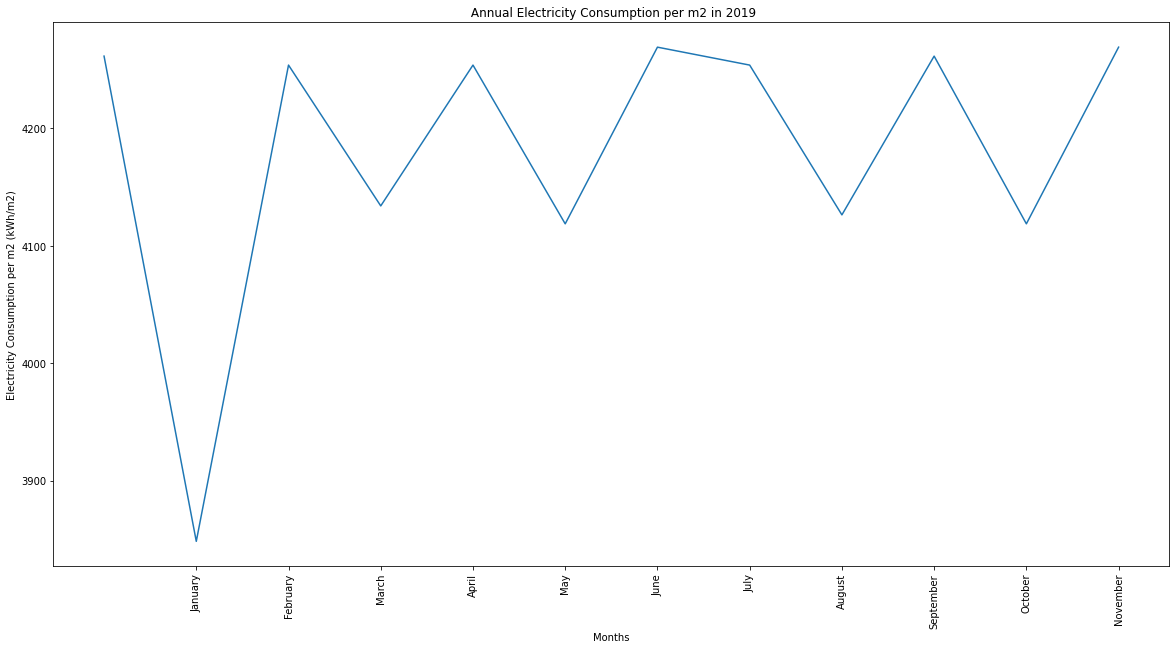

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
labels= data['Date_Time'].values
plt.xticks(np.arange(1, len(x)+1, 1.0))
ax.set_xticklabels(labels)
plt.xticks(rotation='vertical')
plt.xlabel('Months')
plt.ylabel('Electricity Consumption per m2 (kWh/m2)')
plt.title(' Annual Electricity Consumption per m2 in 2019')
plt.plot(y)
plt.show()

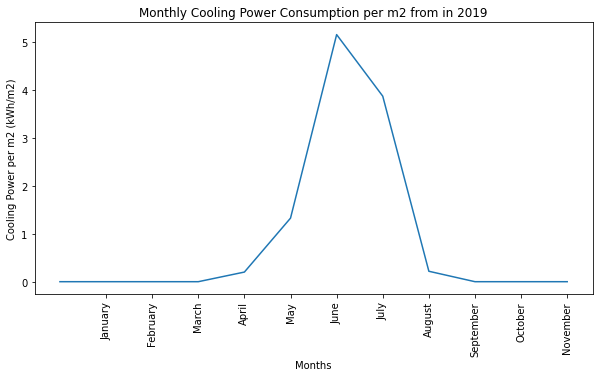

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
labels= data['Date_Time'].values
plt.xticks(np.arange(1, len(x)+1, 1.0))
ax.set_xticklabels(labels)
plt.xticks(rotation='vertical')
plt.plot(data['power_cooling'].values/total_area)
plt.xlabel('Months')
plt.ylabel('Cooling Power per m2 (kWh/m2)')
plt.title('Monthly Cooling Power Consumption per m2 from in 2019')
plt.show()

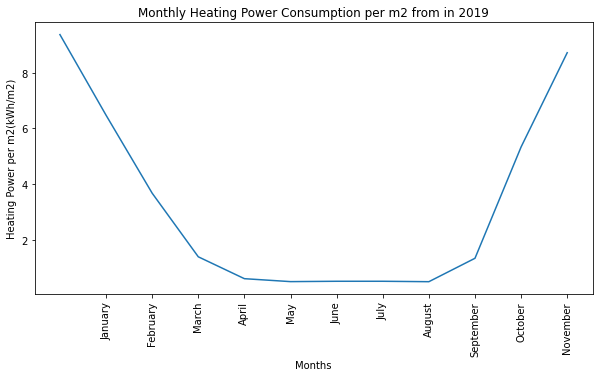

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
labels= data['Date_Time'].values
plt.xticks(np.arange(1, len(x)+1, 1.0))
ax.set_xticklabels(labels)
plt.xticks(rotation='vertical')
plt.plot(data['power_heating'].values/total_area)
plt.xlabel('Months')
plt.ylabel('Heating Power per m2(kWh/m2)')
plt.title('Monthly Heating Power Consumption per m2 from in 2019')
plt.show()
